In [1]:
# get gradient from self.objective_gradient(seq(x,y), deriv_func)  <- need to deply derivative function by itself.
# update_with_gradient(gradient = eligibility function)
# can add gradients

from dataclasses import dataclass
from rl.distribution import Distribution, Constant
from rl.dynamic_programming import evaluate_mrp_result
from rl.chapter2.simple_inventory_mrp import InventoryState, SimpleInventoryMRPFinite
from rl.markov_process import TransitionStep, MarkovRewardProcess, NonTerminal
from typing import Dict, Iterable, TypeVar

import itertools
import numpy as np
import pandas as pd

In [2]:
S = TypeVar("S")


@dataclass
class DynamicLearningRate:
    alpha: float
    beta: float
    H: int

    def evaluate(self, n: int):
        return self.alpha / (1 + ((n - 1) / self.H) ** (self.beta))


@dataclass
class EligibilityTrace:
    trace: Iterable[NonTerminal[S]]

    def __post_init__(self):
        pass


@dataclass
class TabularTDLambda:
    mrp: MarkovRewardProcess
    gamma: float
    lambda_param: float
    dlr: DynamicLearningRate

    def __post_init__(self):
        self.vf_dict: Dict[NonTerminal[S], float] = {
            state: 0.0 for state in self.mrp.non_terminal_states
        }
        self.counter_dict: Dict[NonTerminal[S], int] = {
            state: 0 for state in self.mrp.non_terminal_states
        }

    def process_trace(self, trace: Iterable[TransitionStep[S]], n_iter: int = 100):
        eligibility_trace: Dict[NonTerminal[S], float] = {
            state: 0.0 for state in self.mrp.non_terminal_states
        }
        for state in itertools.islice(trace, n_iter):

            # update each nonterminal state
            for s in self.mrp.non_terminal_states:
                eligibility_trace[s] *= self.gamma * self.lambda_param
                if s == state.state:
                    eligibility_trace[s] += 1
                self.counter_dict[state.state] += 1
                self.vf_dict[s] = (
                    self.vf_dict[s]
                    + (
                        state.reward
                        + self.gamma * self.vf_dict[state.next_state]
                        - self.vf_dict[state.state]
                    )
                    * self.dlr.evaluate(self.counter_dict[state.state])
                    * eligibility_trace[s]
                )

    def td_lambda_tabular_vf(
        self, init_state_dist: Distribution[NonTerminal[S]], n_traces: int = 1_000
    ):
        traces: Iterable[TransitionStep[S]] = self.mrp.reward_traces(init_state_dist)
        for trace in itertools.islice(traces, n_traces):
            self.process_trace(trace=trace)


In [3]:
si_mrp = SimpleInventoryMRPFinite(
    capacity=2,
    poisson_lambda=1.0,
    holding_cost=1.0,
    stockout_cost=10.0,
)

gamma = 0.9
lambda_param = 0.3
#episode_length = 20000

dlr = DynamicLearningRate(alpha=0.03, beta=0.5, H=10_000)
init_state_dist=Constant(NonTerminal(InventoryState(on_hand=0, on_order=0)))

traces: Iterable[TransitionStep[S]] = si_mrp.reward_traces(init_state_dist)
# for tr in itertools.islice(traces, 1):
#     trace = list(itertools.islice(tr, episode_length))

In [4]:
si_mrp = SimpleInventoryMRPFinite(
    capacity=2,
    poisson_lambda=1.0,
    holding_cost=1.0,
    stockout_cost=10.0,
)

gamma = 0.9


dp_vf = evaluate_mrp_result(si_mrp, gamma=0.9)


def vf_rmse(vf1, vf2):
    err = 0
    for state in vf1.keys():
        err += (vf1[state] - vf2[state]) ** 2
    return np.sqrt(err)


dlr = DynamicLearningRate(alpha=0.03, beta=0.5, H=10_000)
batch_size = 1000
n_batches = 20

rmse_dict = {}

for lambda_param in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    running_dict = {state: 0 for state in si_mrp.non_terminal_states}
    rmse_dict[lambda_param] = []
    ttd = TabularTDLambda(mrp=si_mrp, lambda_param=lambda_param, gamma=gamma, dlr=dlr)

    for n in range(n_batches):
        ttd.td_lambda_tabular_vf(
            init_state_dist=Constant(
                NonTerminal(InventoryState(on_hand=0, on_order=0))
            ),
            n_traces=batch_size,
        )
        for state in running_dict.keys():
            running_dict[state] *= ((n) / (n + 1))
            running_dict[state] += (ttd.vf_dict[state] / (n + 1))
        rmse_dict[lambda_param].append(vf_rmse(dp_vf, running_dict))


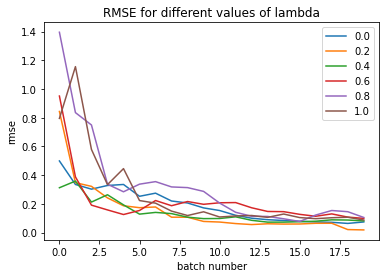

In [5]:
pd.DataFrame(rmse_dict).plot(title="RMSE for different values of lambda", xlabel = "batch number", ylabel = "rmse")
